Goal of Project: Predict whether a person earns more than $50K per year based on census attributes.

Target variable: income (<=50K or >50K)

Features: demographic and financial info like age, education, occupation, work hours, marital status, etc.

Objective- To develop a machine learning model that accurately classifies individuals’ income levels using demographic and socio-economic features from census data.

In [144]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import kagglehub
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from kaggle.api.kaggle_api_extended import KaggleApi
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform
from scipy.stats import randint, uniform
from sklearn.pipeline import Pipeline



from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, accuracy_score, f1_score  # Evaluation metrics

In [73]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [138]:

api = KaggleApi()
api.authenticate()

# Download dataset
api.dataset_download_files(
    "uciml/adult-census-income",
    path="data",
    unzip=True
)

print("Download complete!")

Dataset URL: https://www.kaggle.com/datasets/uciml/adult-census-income
Download complete!


In [75]:
new_cols=['Age', 'WorkClass', 'Final Weight', 'Education', 'Education_Numbers', 'Maratial Status', 'Occupation', 'Relationship', 'Race',
          'Sex', 'Capital_Gain', 'Capital_Loss', 'Hours_P/W', 'country of origin', 'Income']
Data=pd.read_csv(r'C:\Users\k\Desktop\Python1\Census_Income_Analysis\data\adult.csv', names=new_cols, header=0)

In [76]:
Data.head()

,Age,WorkClass,Final Weight,Education,Education_Numbers,Maratial Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_P/W,country of origin,Income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [77]:
#Checking the Sape of Dataset
print("Rows:{} Columns:{}".format(Data.shape[0], Data.shape[1]))

Rows:32561 Columns:15


In [78]:
#Checking Null Values

Data.isna().sum()

Age                  0
WorkClass            0
Final Weight         0
Education            0
Education_Numbers    0
Maratial Status      0
Occupation           0
Relationship         0
Race                 0
Sex                  0
Capital_Gain         0
Capital_Loss         0
Hours_P/W            0
country of origin    0
Income               0
dtype: int64

In [79]:
Data.duplicated().sum()

np.int64(24)

In [80]:
# Check for '?' in dataset
Data.isin(['?']).sum()

Age                     0
WorkClass            1836
Final Weight            0
Education               0
Education_Numbers       0
Maratial Status         0
Occupation           1843
Relationship            0
Race                    0
Sex                     0
Capital_Gain            0
Capital_Loss            0
Hours_P/W               0
country of origin     583
Income                  0
dtype: int64

DATA PREPROCESSING & Exploratory Data Analysis:

Missing values in the dataset are represented by the symbol '?'. we will impute Categorical features by using an "Unknown" category

In [81]:
#Replacing ? with (Unknown) in Catogorical columns

cols=['WorkClass', 'Occupation', 'country of origin']
for col in cols:
    Data[col].replace('?', 'Unknown', inplace=True)

In [82]:
#Checking Data set after replacing ? with unknown

Data.isin(['?']).sum()

Age                  0
WorkClass            0
Final Weight         0
Education            0
Education_Numbers    0
Maratial Status      0
Occupation           0
Relationship         0
Race                 0
Sex                  0
Capital_Gain         0
Capital_Loss         0
Hours_P/W            0
country of origin    0
Income               0
dtype: int64

In [83]:
Data.isna().sum()

Age                  0
WorkClass            0
Final Weight         0
Education            0
Education_Numbers    0
Maratial Status      0
Occupation           0
Relationship         0
Race                 0
Sex                  0
Capital_Gain         0
Capital_Loss         0
Hours_P/W            0
country of origin    0
Income               0
dtype: int64

In [84]:
Data.duplicated().sum()

np.int64(24)

In [85]:
#we see we have some duplicate rows in our dataset, we will drop all duplicate rows

Data.drop_duplicates(inplace=True)

In [86]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32537 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Age                32537 non-null  int64 
 1   WorkClass          32537 non-null  object
 2   Final Weight       32537 non-null  int64 
 3   Education          32537 non-null  object
 4   Education_Numbers  32537 non-null  int64 
 5   Maratial Status    32537 non-null  object
 6   Occupation         32537 non-null  object
 7   Relationship       32537 non-null  object
 8   Race               32537 non-null  object
 9   Sex                32537 non-null  object
 10  Capital_Gain       32537 non-null  int64 
 11  Capital_Loss       32537 non-null  int64 
 12  Hours_P/W          32537 non-null  int64 
 13  country of origin  32537 non-null  object
 14  Income             32537 non-null  object
dtypes: int64(6), object(9)
memory usage: 4.0+ MB


In [87]:
Data.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,32537.0,38.585549,13.637984,17.0,28.0,37.0,48.0,90.0
Final Weight,32537.0,189780.848511,105556.471009,12285.0,117827.0,178356.0,236993.0,1484705.0
Education_Numbers,32537.0,10.081815,2.571633,1.0,9.0,10.0,12.0,16.0
Capital_Gain,32537.0,1078.443741,7387.957424,0.0,0.0,0.0,0.0,99999.0
Capital_Loss,32537.0,87.368227,403.101833,0.0,0.0,0.0,0.0,4356.0
Hours_P/W,32537.0,40.440329,12.346889,1.0,40.0,40.0,45.0,99.0


Data Visualization


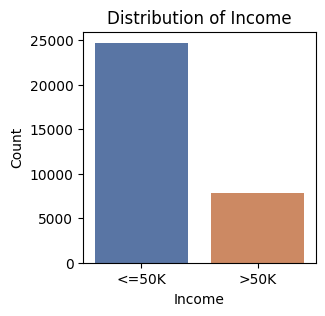

In [88]:
# Creating a barplot to check distribution of dependent variable

plt.figure(figsize=(3,3))

sns.countplot(x='Income', data=Data, palette='deep')
plt.title('Distribution of Income')
plt.xlabel('Income')
plt.ylabel('Count')
plt.show()


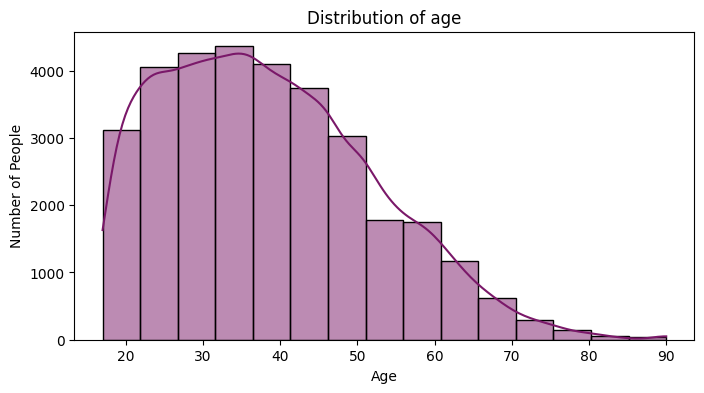

In [89]:
#Creating a distribution plot for age

plt.figure(figsize=(8,4))

sns.histplot(Data['Age'], bins=15,kde=True, color='#7A1869')
plt.title('Distribution of age', fontsize=12)
plt.xlabel('Age')
plt.ylabel('Number of People')
plt.show()


--- WorkClass ---
WorkClass
Private             22673
Self-emp-not-inc     2540
Local-gov            2093
Unknown              1836
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: count, dtype: int64


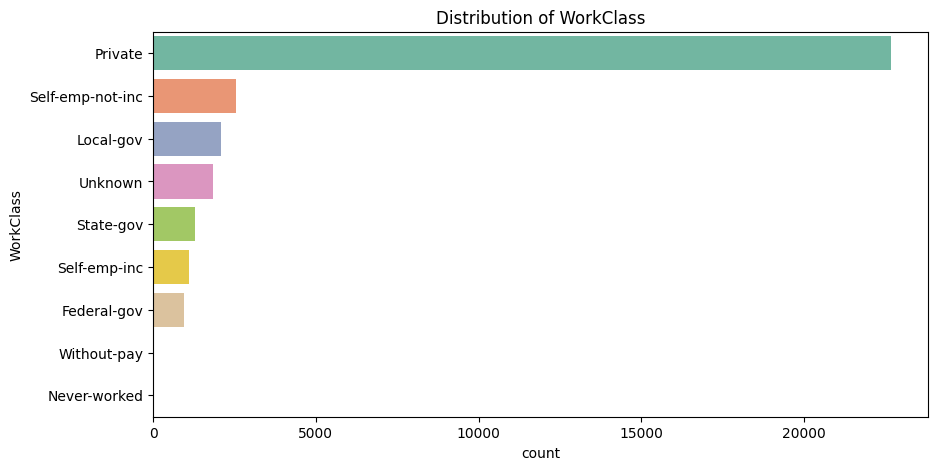


--- Education ---
Education
HS-grad         10494
Some-college     7282
Bachelors        5353
Masters          1722
Assoc-voc        1382
11th             1175
Assoc-acdm       1067
10th              933
7th-8th           645
Prof-school       576
9th               514
12th              433
Doctorate         413
5th-6th           332
1st-4th           166
Preschool          50
Name: count, dtype: int64


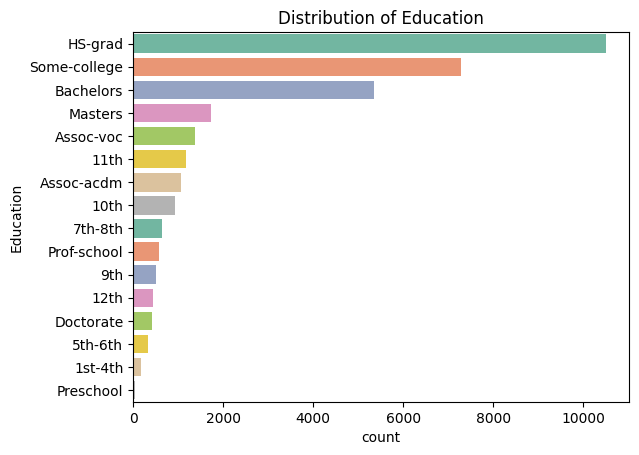


--- Maratial Status ---
Maratial Status
Married-civ-spouse       14970
Never-married            10667
Divorced                  4441
Separated                 1025
Widowed                    993
Married-spouse-absent      418
Married-AF-spouse           23
Name: count, dtype: int64


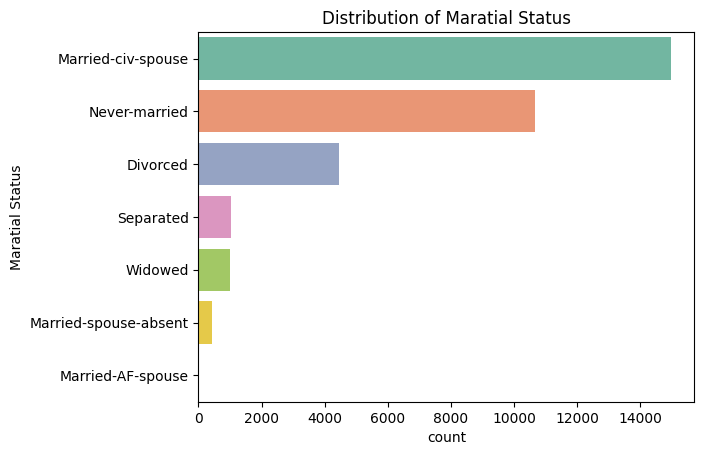


--- Occupation ---
Occupation
Prof-specialty       4136
Craft-repair         4094
Exec-managerial      4065
Adm-clerical         3768
Sales                3650
Other-service        3291
Machine-op-inspct    2000
Unknown              1843
Transport-moving     1597
Handlers-cleaners    1369
Farming-fishing       992
Tech-support          927
Protective-serv       649
Priv-house-serv       147
Armed-Forces            9
Name: count, dtype: int64


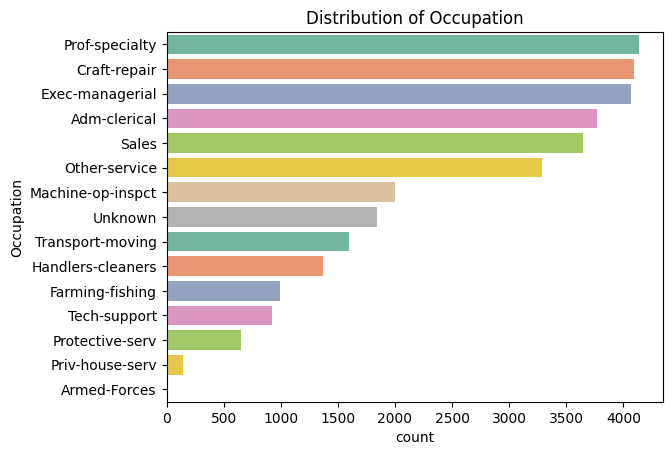


--- Relationship ---
Relationship
Husband           13187
Not-in-family      8292
Own-child          5064
Unmarried          3445
Wife               1568
Other-relative      981
Name: count, dtype: int64


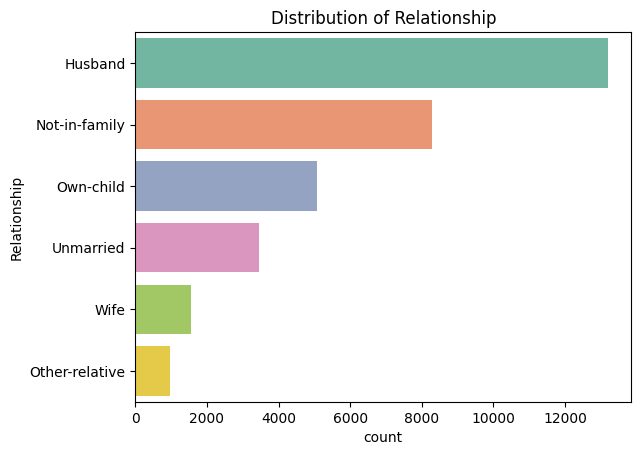


--- Race ---
Race
White                 27795
Black                  3122
Asian-Pac-Islander     1038
Amer-Indian-Eskimo      311
Other                   271
Name: count, dtype: int64


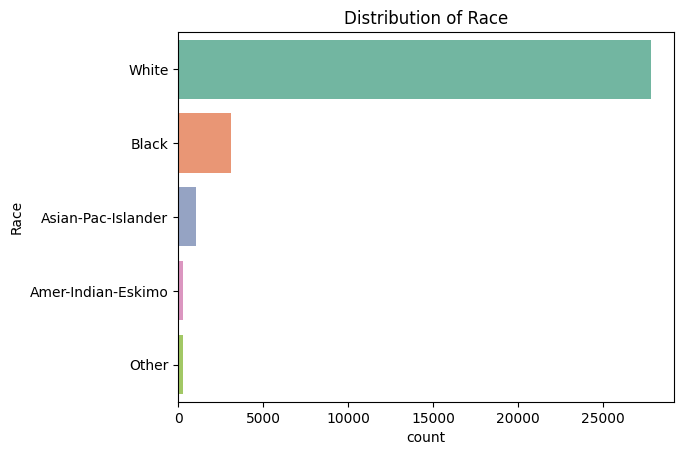


--- Sex ---
Sex
Male      21775
Female    10762
Name: count, dtype: int64


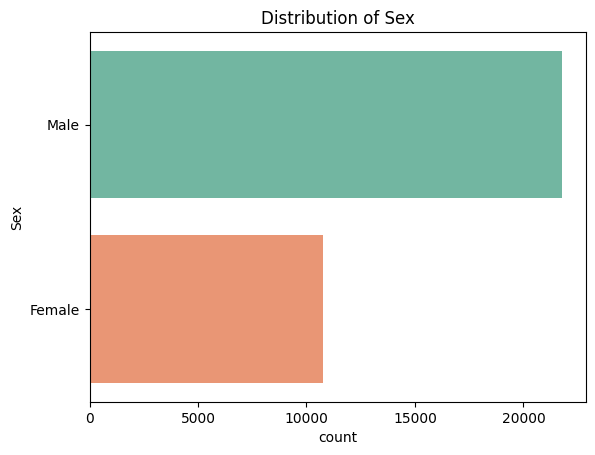

In [90]:
#Countplot for Catogorical columns

plt.figure(figsize=(10,5))
cat_cols = ['WorkClass', 'Education', 'Maratial Status', 'Occupation', 'Relationship', 'Race', 'Sex']

for col in cat_cols:
    print(f"\n--- {col} ---")
    print(Data[col].value_counts())
    sns.countplot(y=col, data=Data, order=Data[col].value_counts().index, palette='Set2')
    plt.title(f'Distribution of {col}')
    plt.show()


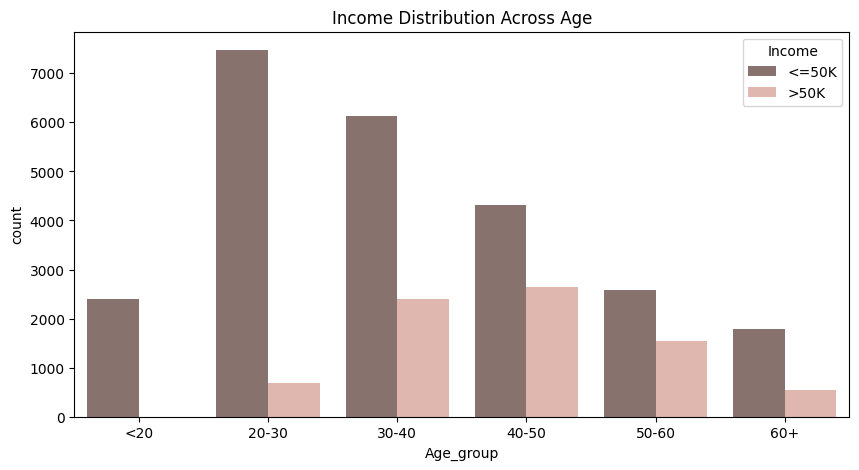

In [91]:
# Creating a plot of income across age
Data['Age_group'] = pd.cut(
    Data['Age'],
    bins=[0, 20, 30, 40, 50, 60, 100],
    labels=['<20','20-30','30-40','40-50','50-60','60+']
)

plt.figure(figsize=(10, 5))
sns.countplot(data=Data, x='Age_group', hue='Income',palette=['#8C6F69', '#E8B2A7'])
plt.title('Income Distribution Across Age', fontsize=12)
plt.show()


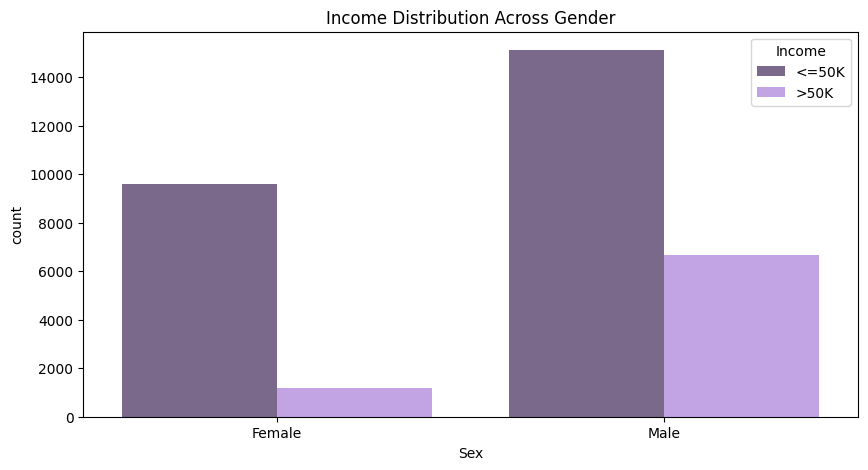

In [92]:
# Creating a plot of income across Gender

plt.figure(figsize=(10, 5))
sns.countplot(data=Data, x='Sex', hue='Income',palette=['#7A638F', '#C199F0'])
plt.title('Income Distribution Across Gender', fontsize=12)
plt.show()


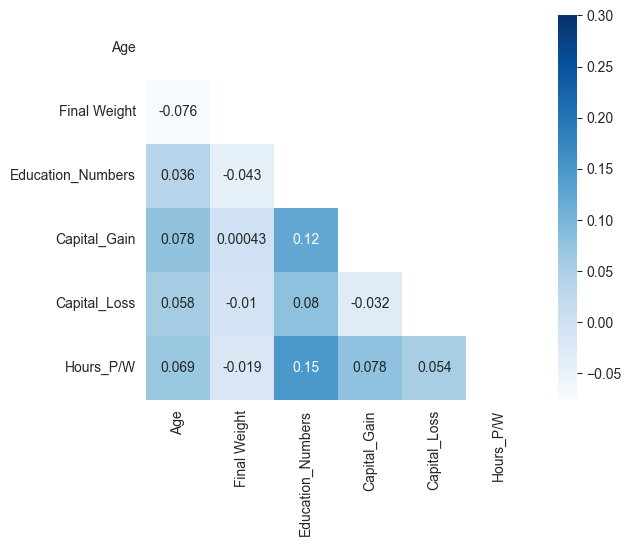

In [93]:
corr=Data.corr(numeric_only=True)

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(7, 5))
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True,
                        annot=True, cmap='Blues')
    plt.show()

Observations:
    
In this dataset, the most number of people are young, white, male, high school graduates with 9 to 10 years of education and work 40 hours per week.

From the correlation heatmap, we can see that the dependent feature 'income' is highly correlated with age, numbers of years of education, capital gain and number of hours per week.

Feature Engineering 

-Encoding

Label Encoding → target variable, categorical Variables


In [94]:
#Transforming Target Variables
Le=LabelEncoder()
Le.fit_transform(Data['Income'])


array([0, 0, 0, ..., 1, 0, 0], shape=(32537,))

In [95]:
#Transforming categorical Variables
for col in Data.columns:
    if Data[col].dtype=='object':
        Data[col]=Le.fit_transform(Data[col])
        
    

In [96]:
Data['Age_group'].value_counts()

Age_group
30-40    8543
20-30    8153
40-50    6977
50-60    4128
<20      2405
60+      2331
Name: count, dtype: int64

Feature Selection Using RFE


In [97]:
for col in Data.columns:
    if Data[col].dtype=='category':
        Data[col]=Le.fit_transform(Data[col])

In [98]:
#seperating X and Y variables
X=Data.drop('Income', axis=1)
y=Data['Income']

In [99]:
#seperating X and Y variables
X=Data.drop('Income', axis=1)
y=Data['Income']

selected Features by RFE : ['Age', 'Final Weight', 'Education_Numbers', 'Occupation', 'Relationship', 'Capital_Gain', 'Hours_P/W']


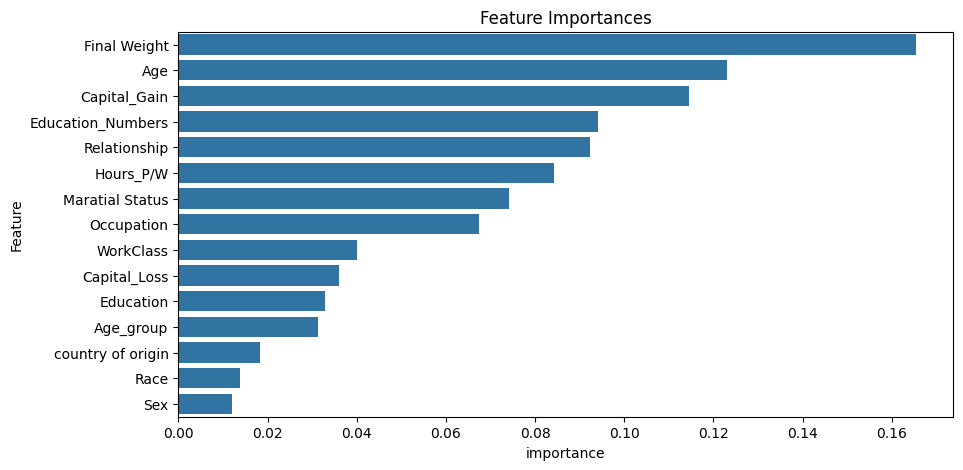

In [100]:

#numerical values
for col in X.columns:
  if X[col].dtype == "object":
    X[col] = pd.factorize(X[col])[0]


rf=RandomForestClassifier(n_estimators=120, random_state=42)
rfe=RFE(estimator=rf, n_features_to_select=7)
rfe.fit(X, y)

selected_features=[feature for feature, selected in zip(X.columns, rfe.support_)if selected]
print(f"selected Features by RFE : {selected_features}")
rf.fit(X,y)


importances=pd.DataFrame({'Feature':X.columns, 'importance':rf.feature_importances_ })
importances=importances.sort_values('importance', ascending=False)
importances


#Plot

plt.figure(figsize=(10,5))
sns.barplot(x='importance', y='Feature', data=importances)
plt.title('Feature Importances')
plt.show()



USING RFE for Feature selection we see

work_class, capital loss, education, age_group,country of origin, race and sex are not important features for our model so we will go and drop them before building our model

In [101]:
X.columns

Index(['Age', 'WorkClass', 'Final Weight', 'Education', 'Education_Numbers',
       'Maratial Status', 'Occupation', 'Relationship', 'Race', 'Sex',
       'Capital_Gain', 'Capital_Loss', 'Hours_P/W', 'country of origin',
       'Age_group'],
      dtype='object')

In [102]:
X=X.drop(['WorkClass', 'Capital_Loss', 'Education', 'Age_group','country of origin', 'Race','Sex'],axis=1)

Data Splitting


In [103]:
#splitting Data into Train Test split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=42)


# Print the shape (rows, columns) of the training and test feature sets
print(f"\nTraining set shape: {X_train.shape}, Test set shape: {X_test.shape}")
# Print the normalized distribution (as percentages) of the target classes in the training set
print(f"Training target distribution:\n{y_train.value_counts(normalize=True)}")
# Print the normalized distribution (as percentages) of the target classes in the test set
print(f"Test target distribution:\n{y_test.value_counts(normalize=True)}")




Training set shape: (26029, 8), Test set shape: (6508, 8)
Training target distribution:
Income
0    0.757232
1    0.242768
Name: proportion, dtype: float64
Test target distribution:
Income
0    0.766441
1    0.233559
Name: proportion, dtype: float64


Feature Scaling :

We scale features so models treat all features fairly and learn efficiently.

In [104]:
scaler=StandardScaler()

X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

Handle Class Imbalance:

In [106]:
smote = SMOTE(random_state=42)  # Initialize SMOTE to handle class imbalance by generating synthetic minority samples

#applying SMOTE on Training Data to resample and balance the class

X_train_resample, y_train_resample=smote.fit_resample(X_train, y_train)

#print resample Data shape
print(f"Resampled Training set shape: {X_train_resample.shape}")

# Print the class distribution after resampling (should be balanced)
print(f"Resampled Training class distribution:\n {y_train_resample.value_counts(normalize=True)} ")

Resampled Training set shape: (39420, 8)
Resampled Training class distribution:
 Income
0    0.5
1    0.5
Name: proportion, dtype: float64 


Model LogisticRegression

Accuracy (Lr): 0.8224
F1_Score (Lr): 0.5372

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.94      0.89      4988
           1       0.69      0.44      0.54      1520

    accuracy                           0.82      6508
   macro avg       0.77      0.69      0.71      6508
weighted avg       0.81      0.82      0.81      6508



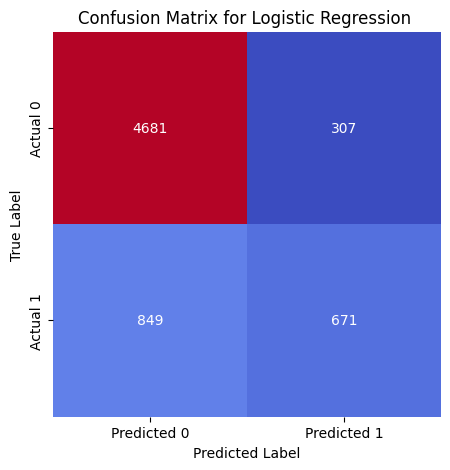

In [121]:
Model_lr=LogisticRegression()

Model_lr.fit(X_train, y_train)

y_pred_lr=Model_lr.predict(X_test)


#accuracy socre
accuracy_Lr = accuracy_score(y_test, y_pred_lr)
print(f"Accuracy (Lr): {accuracy_Lr:.4f}")

F1_Score_lr=f1_score(y_test, y_pred_lr)
print(f"F1_Score (Lr): {F1_Score_lr:.4f}")


print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))

cm=confusion_matrix(y_test, y_pred_lr)


#plotting confusion matrix
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='d',cmap='coolwarm',cbar=False,
            xticklabels=['Predicted 0','Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix for Logistic Regression ')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Model DecisionTreeClassifier

Accuracy (DTC): 0.8024
F1_Score (DTC): 0.5862

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.86      0.87      4988
           1       0.57      0.60      0.59      1520

    accuracy                           0.80      6508
   macro avg       0.72      0.73      0.73      6508
weighted avg       0.81      0.80      0.80      6508



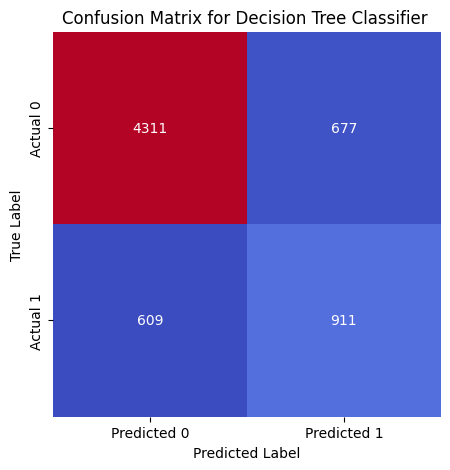

In [125]:
Model_DTC=DecisionTreeClassifier()
Model_DTC.fit(X_train, y_train)

Model_dtc=Model_DTC.predict(X_test)


#accuracy socre
accuracy_Dtc = accuracy_score(y_test, Model_dtc)
print(f"Accuracy (DTC): {accuracy_Dtc:.4f}")

F1_Score_dtc=f1_score(y_test, Model_dtc)
print(f"F1_Score (DTC): {F1_Score_dtc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test,Model_dtc))

cm1=confusion_matrix(y_test,Model_dtc)


#plotting confusion matrix
plt.figure(figsize=(5,5))
sns.heatmap(cm1, annot=True, fmt='d',cmap='coolwarm',cbar=False,
            xticklabels=['Predicted 0','Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix for Decision Tree Classifier ')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Model Random Forest Classifier


Accuracy (RFC): 0.8460
F1_Score (RFC): 0.6504

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.92      0.90      4988
           1       0.69      0.61      0.65      1520

    accuracy                           0.85      6508
   macro avg       0.79      0.77      0.78      6508
weighted avg       0.84      0.85      0.84      6508



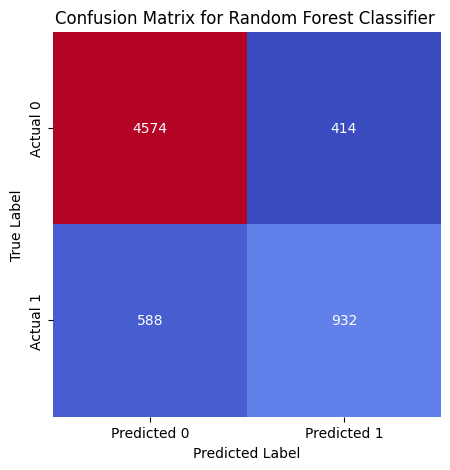

In [127]:
Model_rfc=RandomForestClassifier(n_estimators=120, random_state=42)
Model_rfc.fit(X_train, y_train)

y_pred_rfc=Model_rfc.predict(X_test)


#accuracy socre
accuracy_rfc = accuracy_score(y_test, y_pred_rfc)
print(f"Accuracy (RFC): {accuracy_rfc:.4f}")

F1_Score_dtc=f1_score(y_test, y_pred_rfc)
print(f"F1_Score (RFC): {F1_Score_dtc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test,y_pred_rfc))

cm2=confusion_matrix(y_test,y_pred_rfc)


#plotting confusion matrix
plt.figure(figsize=(5,5))
sns.heatmap(cm2, annot=True, fmt='d',cmap='coolwarm',cbar=False,
            xticklabels=['Predicted 0','Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix for Random Forest Classifier ')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Model XGBoostClassifier


Accuracy (xgb): 0.8605
F1_Score (xgb): 0.6854

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91      4988
           1       0.72      0.65      0.69      1520

    accuracy                           0.86      6508
   macro avg       0.81      0.79      0.80      6508
weighted avg       0.86      0.86      0.86      6508



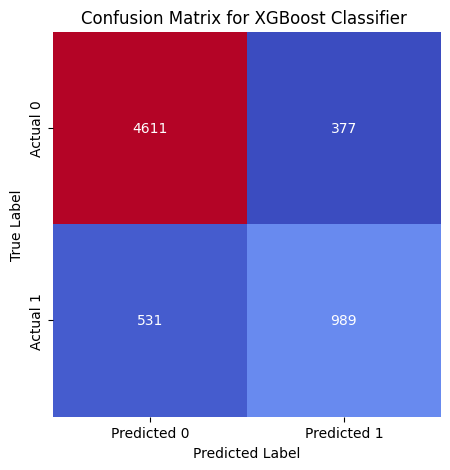

In [128]:
Model_xgb=XGBClassifier()
Model_xgb.fit(X_train, y_train)

y_pred_xgb=Model_xgb.predict(X_test)

#accuracy socre
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"Accuracy (xgb): {accuracy_xgb:.4f}")

F1_Score_dtc=f1_score(y_test, y_pred_xgb)
print(f"F1_Score (xgb): {F1_Score_dtc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test,y_pred_xgb))

cm2=confusion_matrix(y_test,y_pred_xgb)


#plotting confusion matrix
plt.figure(figsize=(5,5))
sns.heatmap(cm2, annot=True, fmt='d',cmap='coolwarm',cbar=False,
            xticklabels=['Predicted 0','Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix for XGBoost Classifier ')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Hyperparameter Tuning

In [ ]:
rf = RandomForestClassifier(random_state=42)

rf_params = {
    'n_estimators': randint(100, 300),
    'max_depth': randint(5, 30),
    'min_samples_split': randint(2, 10),
    'class_weight': [None, 'balanced']
}

rf_search = RandomizedSearchCV(
    rf, rf_params, n_iter=20, scoring='f1', cv=5, random_state=42
)

rf_search.fit(X_train, y_train)

print("Random Forest Best Params:", rf_search.best_params_)


Random Forest Best Params: {'class_weight': 'balanced', 'max_depth': 19, 'min_samples_split': 7, 'n_estimators': 289}


In [137]:
#Building Model with Best hyperparameters found 

best_rf = RandomForestClassifier(
    **rf_search.best_params_,
    random_state=42)

best_rf.fit(X_train, y_train)

y_pred_bestrf = best_rf.predict(X_test)

accuracy_bestrf = accuracy_score(y_test, y_pred_bestrf)
print(f"Accuracy (bestrf): {accuracy_bestrf:.4f}")

print("F1 Score:", f1_score(y_test, y_pred_bestrf))
print(classification_report(y_test, y_pred_bestrf))



Accuracy (bestrf): 0.8356
F1 Score: 0.68931475029036
              precision    recall  f1-score   support

           0       0.93      0.85      0.89      4988
           1       0.62      0.78      0.69      1520

    accuracy                           0.84      6508
   macro avg       0.77      0.82      0.79      6508
weighted avg       0.85      0.84      0.84      6508



In [145]:
xgb = XGBClassifier(
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False
)

xgb_params = {
    'n_estimators': randint(100, 400),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    
}

xgb_search = RandomizedSearchCV(
    xgb,
    xgb_params,
    n_iter=20,
    scoring='f1',
    cv=5,
    random_state=42,
    n_jobs=-1
)

xgb_search.fit(X_train, y_train)

print("XGBoost Best Params:", xgb_search.best_params_)


XGBoost Best Params: {'colsample_bytree': np.float64(0.7123738038749523), 'learning_rate': np.float64(0.1185392166316497), 'max_depth': 3, 'n_estimators': 256, 'subsample': np.float64(0.9208787923016158)}


In [146]:

final_model_xgb = Pipeline(steps=[
    ('scaler', scaler),   # optional for XGB
    ('xgb', XGBClassifier(
        **xgb_search.best_params_,
        random_state=42,
        eval_metric='logloss',
        n_jobs=-1
    ))
])


In [148]:
final_model_xgb.fit(X_train, y_train)

y_pred_RS_xgb = final_model_xgb.predict(X_test)


accuracy_bestrf = accuracy_score(y_test, y_pred_RS_xgb)
print(f"Accuracy (bestrf): {accuracy_bestrf:.4f}")

print("F1 Score:", f1_score(y_test, y_pred_RS_xgb))
print(classification_report(y_test, y_pred_RS_xgb))


Accuracy (bestrf): 0.8656
F1 Score: 0.6909219357117626
              precision    recall  f1-score   support

           0       0.90      0.93      0.91      4988
           1       0.75      0.64      0.69      1520

    accuracy                           0.87      6508
   macro avg       0.82      0.79      0.80      6508
weighted avg       0.86      0.87      0.86      6508



So, as we can see we are getting some good with our XGBoost model after hyperparameter tuning using RandomSearchCV. Now, we will use this model in production